#   [Overview] Machine Learning Model for determining a hit song
###     This is a quick overview of the required steps in order to create this model for binary classification via linear regression
    1. Import packages, read data
    2. Prepare Data
    3. Process Data
    4. Train Model
    5. Evaluate Model
    6. Tune hyper-parameters
***

## Import Packages
    Here we will install the required packages, we will be using `pandas` to visualize data. `sklearn` is the our library in order to use machine learning on Python. 

    Important notes, if using google collab to train the data please run this script first.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/{folder_name}
%pwd

    After running these scripts, go ahead and follow through with the rest of the notebook.

In [186]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Prepare Data, and reading it in.
    I decided on the arbitrary number `75` to consider if a song is currently popular or not. Modify to fit needs such as class imbalances.


In [187]:
from datetime import datetime

def calculate_song_age(release_year, release_month, release_day):
    # Define the end date as December 31, 2022
    end_date = datetime(2023, 1, 1)
    
    # Check if only the year is given (no month and day), then use January 1st of that year as the release date
    if release_month is None or release_day is None:
        release_date = datetime(release_year, 1, 1)
    else:
        # Create a datetime object for the release date
        release_date = datetime(release_year, release_month, release_day)
    
    # Calculate the difference in days between the release date and the end date
    age_in_days = (end_date - release_date).days
    return age_in_days

In [188]:
# importing and reading Data
# Estimated percentiles on this data
# 84 -> 10%
# 81 -> 20%
# 78-79 -> 30%
# 76 -> 40%

popLimit = 81

data = pd.read_csv("spotify_api_data.csv")

# adding the popular tag to data
data['isPopular'] = data['popularity'] > popLimit
data.value_counts('isPopular')
## While there is a slight class inbalance, I think it is acceptable enough for what I'm working towards
data['explicit'] = data['explicit'].astype(int)
data['isPopular'] = data['isPopular'].astype(int)

def convert_date(entry):
    if isinstance(entry, int) or (isinstance(entry, str) and entry.isdigit()):
        # if the entry is an integer or a string of digits, assume it's a year and create a full date with January 1st
        return pd.to_datetime(f'{entry}-01-01')
    else:
        # otherwise, use pandas to parse the date normally
        return pd.to_datetime(entry, errors='coerce')  # 'coerce' will set invalid parsing as NaT

data['date'] = data['date'].apply(convert_date)
data['releaseDate'] = data['releaseDate'].apply(convert_date)
data['year'] = data['date'].dt.year
data['release_year'] = data['releaseDate'].dt.year
data['release_month'] = data['releaseDate'].dt.month
data['release_day'] = data['releaseDate'].dt.day
# Iterative Approach where I try some stuff out
data['comboEnergyDance'] = data['energy'] * data['danceability']
data['songAge'] = data.apply(lambda row: calculate_song_age(row['release_year'], 
                                                            row['release_month'], 
                                                            row['release_day']), axis=1) 

data.drop(['date', 'mode', 'timeSig', 'releaseDate', 'name', 'id', 'album_Name', 'author', 'instrumentalness'], axis=1, inplace=True)
print(data.value_counts('isPopular'))


categorical_features = ['albumType']
onehot_encoder = OneHotEncoder(sparse_output=False) 

ct = ColumnTransformer(
    [('onehot', onehot_encoder, categorical_features)],
    remainder='passthrough'  # Keeps the rest of the columns that are not transformed
)

encoded_features = ct.fit_transform(data)

encoded_feature_names = ct.named_transformers_['onehot'].get_feature_names_out(input_features=categorical_features)

# Get the rest of the column names for columns that were not transformed
# This does not include the categorical columns we one-hot encoded
remainder_column_names = [col for col in data.columns if col not in categorical_features]

# Combine one-hot encoded feature names with remainder column names
all_feature_names = list(encoded_feature_names) + remainder_column_names

data_encoded = pd.DataFrame(encoded_features, columns=all_feature_names)

isPopular
0    1359
1     339
Name: count, dtype: int64


## **Baseline Comparison**
    Before applying my nifty tricks, we should first establish a baseline understanding before we go through all techniques and skills used to make more effective models.

In [189]:
## NO KFOLDS NO CLASS WEIGHTS NO MODIFIED TEST SIZE
# following conventional methods
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X = data_encoded.drop(['isPopular', 'popularity'], axis=1)
y = data_encoded['isPopular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
model = LogisticRegression(max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
print("Number of iterations:", model.n_iter_)

# Predicting the test set results
y_pred = model.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculating precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculating the ROC-AUC score
# For ROC-AUC, you'll need the probabilities of the positive class
y_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

print(f'ROC-AUC Score: {roc_auc:.2f}')

Number of iterations: [44]
Accuracy: 0.80
Precision: 0.48
Recall: 0.15
F1 Score: 0.23
ROC-AUC Score: 0.70


## Updated Model
    Here we try to create test splitted data to base off of popularity while using cross validation, class weights, as well kfold statistics.

In [190]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=None)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

## Linear Regression Model (Ryan's Model)

> Here we will use a linear regression model with sklearn packages to train a model on the data we have.
> Employing several techniques like class-weights, cross validation, new thresholds, and such inorder to get better scores for the model

In [191]:
# Create a Logistic Regression classifier
model = LogisticRegression(max_iter = 1000, class_weight={0:1, 1:2})

scores = cross_val_score(model, X, y, cv=kf)

# Print the accuracy for each fold
print(f"Accuracies for each fold: {scores}")

# Print the mean accuracy and the standard deviation
print(f"Mean accuracy: {np.mean(scores)}")
print(f"Standard deviation: {np.std(scores)}")

Accuracies for each fold: [0.81176471 0.80588235 0.77058824 0.80825959 0.74926254]
Mean accuracy: 0.7891514836022905
Standard deviation: 0.024868138997036555


In [192]:
# Train the model
model.fit(X_train, y_train)
print("Number of iterations:", model.n_iter_)

Number of iterations: [53]


In [193]:
# Grab metrics of model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Predicting the test set results
y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test)[:, 1]

new_threshold = 0.35  # This is just an example value

# Convert probabilities to 0 or 1 based on the new threshold
y_pred_new_threshold = (y_probs >= new_threshold).astype(int)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred_new_threshold)
print(f'Accuracy: {accuracy:.2f}')

# Calculating precision, recall, and F1 score
precision = precision_score(y_test, y_pred_new_threshold)
recall = recall_score(y_test, y_pred_new_threshold)
f1 = f1_score(y_test, y_pred_new_threshold)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculating the ROC-AUC score
# For ROC-AUC, you'll need the probabilities of the positive class
y_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

print(f'ROC-AUC Score: {roc_auc:.2f}')

Accuracy: 0.69
Precision: 0.26
Recall: 0.67
F1 Score: 0.38
ROC-AUC Score: 0.74


### Optional shuffling to check accuracy on shuffled tests.

In [194]:
from sklearn.utils import shuffle

# Shuffle the target labels
y_shuffled = shuffle(y_train, random_state=42)

# Train the model on the shuffled target
model.fit(X_train, y_shuffled)

# Evaluate on the original test set
y_pred_shuffled = model.predict(X_test)
accuracy_shuffled = accuracy_score(y_test, y_pred_shuffled)
print(f'Accuracy on shuffled labels: {accuracy_shuffled:.2f}')


Accuracy on shuffled labels: 0.86


### Visulizations

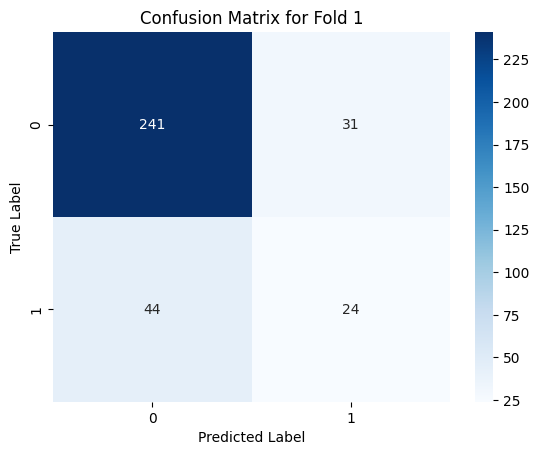

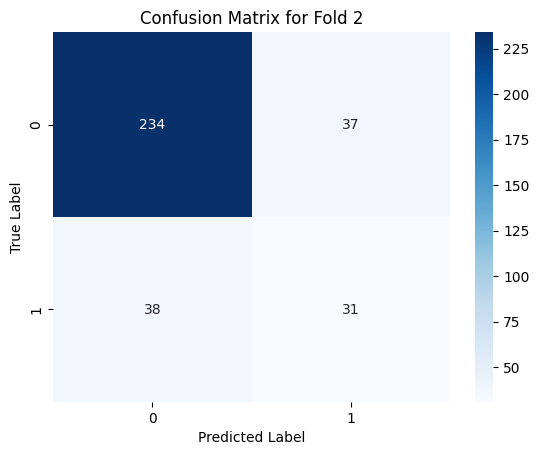

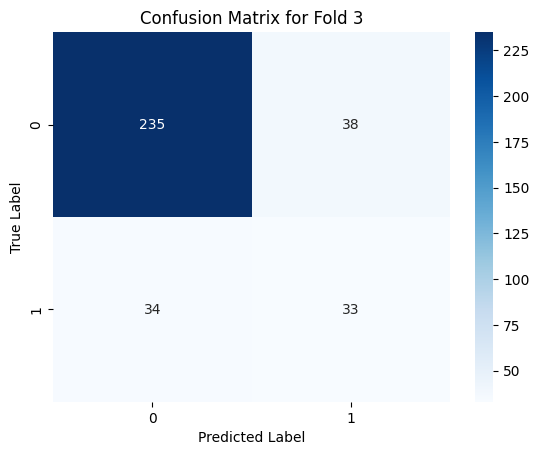

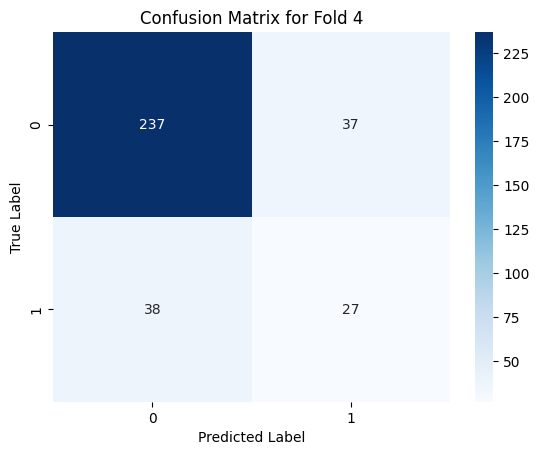

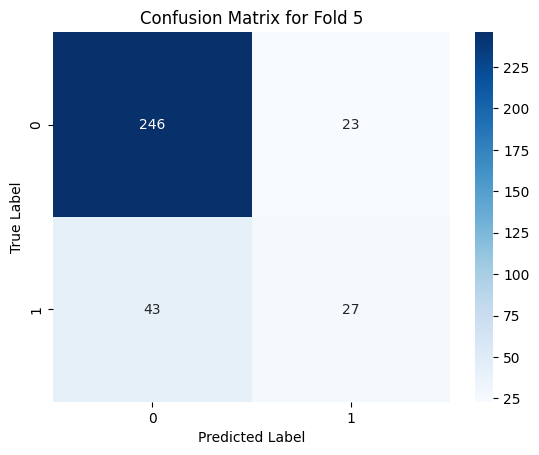

In [195]:
conf_matrices = []
from sklearn.metrics import confusion_matrix
import numpy as np

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrices.append(confusion_matrix(y_test, y_pred))

# Now, you can plot each confusion matrix
for i, matrix in enumerate(conf_matrices):
    plt.figure()
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Visualization Results (By Ryan)
    - Overall, while the model shows a good capacity for avoiding false alarms in predicting hits, its utility is currently limited by its low hit detection rate. For a music industry stakeholder, missing out on true hits could represent a significant lost opportunity. 
    - Therefore, improving the recall should be a priority, even if it means accepting a slight increase in false positives, which in a business context, might be a less costly error. 
    - The model's predictive ability can be improved by focusing on better capturing the patterns that distinguish hits, we will have to gather additional from previous years to get a better temporal sense for the model.

## Gradient Boosted Tree Model (Ryan's Model)
    Here we will use a Gradient Boosted model with xgboost packages to train a model on the data we have.

In [196]:
import xgboost as xgb

In [197]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up the XGBoost parameters
# Start with default parameters, then you can tune them later
params = {
    'device': 'cuda',
    'max_depth': 10,
    'eta': 0.25,
    'objective': 'binary:hinge',  # Use 'binary:logistic' for binary classification problems
    'eval_metric': 'logloss',        # Use 'logloss' for evaluation metric of binary classification
}

# Train the model
# 'num_boost_round' is equivalent to the number of trees
bst = xgb.train(params, dtrain, num_boost_round=100)

y_pred_proba = bst.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)  # Thresholding at 0.5

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Notice that we use y_pred_proba here

# Print out the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")




Accuracy: 0.79
Recall: 0.37
Precision: 0.48
F1 Score: 0.42
ROC-AUC Score: 0.63


## Visualizations for Gradient Boost

<Figure size 1000x800 with 0 Axes>

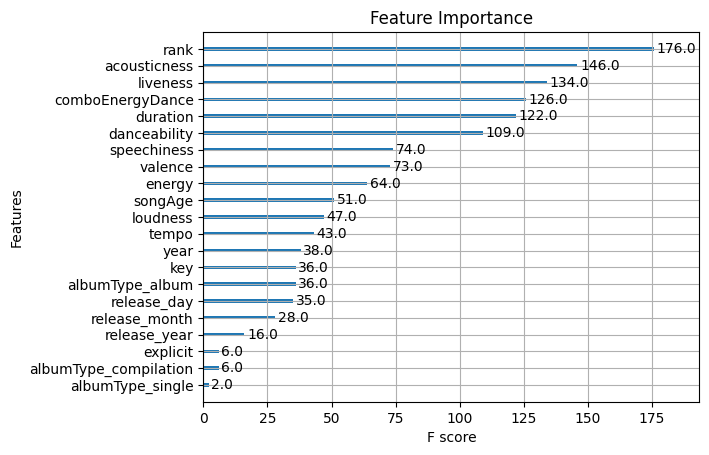

In [198]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(bst)
plt.title('Feature Importance')
plt.show()

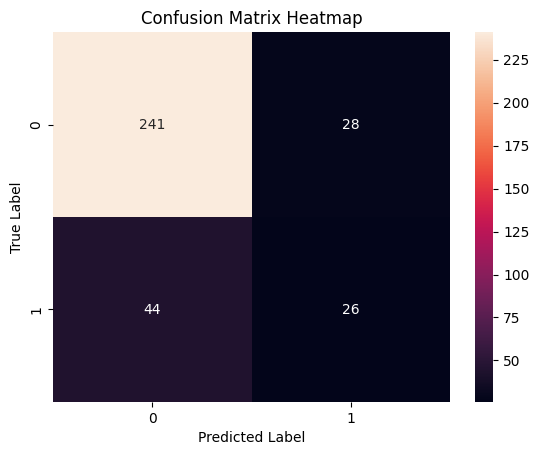

In [199]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **Feature Important Visualization**
    The feature importance visualization is useful for understanding which features our model is focusing on and gave us more information and retrospect in feature selection, and engineering those features. We've noticed that is has an over reliance on rank, which we are currently unsure is a good thing, but maybe with additional data we'll have a better understanding on if rank is a beneficial feature. Surprisingly enough, duration and liveness were the 2nd most common set of features that were used in the decision process. 

### **Confusion Heatmap Matrix**
    Using the gradient boost model instead of a basic linear regression, we can very similar trends in the data where there are a high amount of true negatives, and moderate values of FP, TP, and FN. We will have to gather more data and refine this model to account for inbalances.

## Conclusions
    The refined models do have have better general performance in comparison to our baseline model. While our intention was to get a model that had good general abiltiy to determine hits, we might have to work towards refining our data and model to have higher accuracy while having better general predictions.